**Business licenses dataset issued by the Department of Business Affairs and Consumer Protection in the City of Chicago from 
2002 to the present**

**Building a decision tree classifier that would yield a decision for conditional approval of a new person**

Dataset - https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr/data

### Installing Libraries

In [1]:
# # tool for plotting
# install.packages("ggplot2")
# # tool to fit decision trees
# install.packages("rpart")
# # to plot trees
# install.packages("rpart.plot")
# # data summarization
# install.packages("psych")
# install.packages("writexl")
# install.packages("dplyr")
# install.packages("rsample")
# install.packages("caret")
# install.packages("ROSE")
# install.packages("pROC")

### Load Libraries

In [39]:
library("psych")
library("ggplot2")
library("writexl")
library("dplyr")
library("caret")
library("ROSE")
library(rpart)
library(pROC)
library(rpart.plot)
library(zoo)


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




### Load the Dataset

In [3]:
# load the dataset path and filename
path <- "./"
filename <- "Business_Licenses.csv"

In [4]:
# setting to current working directory
setwd(path)

In [6]:
# load the csv file
data <- read.csv(filename)
head(data, 5)

,ID,LICENSE.ID,ACCOUNT.NUMBER,SITE.NUMBER,LEGAL.NAME,DOING.BUSINESS.AS.NAME,ADDRESS,CITY,STATE,ZIP.CODE,⋯,LICENSE.STATUS.CHANGE.DATE,SSA,LATITUDE,LONGITUDE,LOCATION,Community.Areas,Historical.Wards.2003.2015,Zip.Codes,Census.Tracts,Wards
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>
1,16570-20000216,76522,51755,1,THORNDALE CONSTRUCTION,THORNDALE CONSTRUCTION,11243 CHESAPEAKE PLAC 1ST,WESTCHESTER,IL,60154,⋯,,NA,NA,NA,,NA,NA,NA,NA,NA
2,25710-19960216,119268,52896,1,"PAT HAMILTON, INC",PAT HAMILTON CO.,17021 S MAGNOLIA DR 1ST,HAZEL CREST,IL,60429,⋯,,NA,NA,NA,,NA,NA,NA,NA,NA
3,53383-20150316,2375632,38691,1,MEE INC,MEE INC,11845 W LARAWAY RD 1,FRANKFORT,IL,60423,⋯,,NA,NA,NA,,NA,NA,NA,NA,NA
4,1847540-20090116,1940503,89020,45,"FEDEX OFFICE AND PRINT SERVICES, INC.","FEDEX OFFICE AND PRINT SVCS, INC.",2301 S DR MARTIN LUTHER KING JR DR SOUTH BL,CHICAGO,IL,60616,⋯,,NA,NA,NA,,NA,NA,NA,NA,NA
5,50776-20040216,1458339,56730,1,FREDERICK MCGEE,MCGEE'S REMODELING,1009 S 11TH AVE 1,MAYWOOD,IL,60153,⋯,,NA,NA,NA,,NA,NA,NA,NA,NA


In [7]:
# internal structure of data dataframe
str(data)

'data.frame':	1112069 obs. of  39 variables:
 $ ID                               : chr  "16570-20000216" "25710-19960216" "53383-20150316" "1847540-20090116" ...
 $ LICENSE.ID                       : int  76522 119268 2375632 1940503 1458339 275807 286129 2858237 1660219 2454132 ...
 $ ACCOUNT.NUMBER                   : int  51755 52896 38691 89020 56730 19866 59758 62544 54914 61178 ...
 $ SITE.NUMBER                      : int  1 1 1 45 1 1 1 3 1 3 ...
 $ LEGAL.NAME                       : chr  "THORNDALE CONSTRUCTION" "PAT HAMILTON, INC" "MEE INC" "FEDEX OFFICE AND PRINT SERVICES, INC." ...
 $ DOING.BUSINESS.AS.NAME           : chr  "THORNDALE CONSTRUCTION" "PAT HAMILTON CO." "MEE INC" "FEDEX OFFICE AND PRINT SVCS, INC." ...
 $ ADDRESS                          : chr  "11243  CHESAPEAKE PLAC   1ST" "17021 S MAGNOLIA DR  1ST" "11845 W LARAWAY RD  1" "2301 S DR MARTIN LUTHER KING JR DR  SOUTH BL" ...
 $ CITY                             : chr  "WESTCHESTER" "HAZEL CREST" "FRANKFORT" "CH

In [8]:
# summarize the dataframe
summary(data)

      ID              LICENSE.ID      ACCOUNT.NUMBER    SITE.NUMBER     
 Length:1112069     Min.   :    364   Min.   :     1   Min.   :  1.000  
 Class :character   1st Qu.:1556370   1st Qu.: 36891   1st Qu.:  1.000  
 Mode  :character   Median :1937826   Median :222183   Median :  1.000  
                    Mean   :1978114   Mean   :194184   Mean   :  4.793  
                    3rd Qu.:2394748   3rd Qu.:322608   3rd Qu.:  2.000  
                    Max.   :2934020   Max.   :501309   Max.   :644.000  
                                                                        
  LEGAL.NAME        DOING.BUSINESS.AS.NAME   ADDRESS         
 Length:1112069     Length:1112069         Length:1112069    
 Class :character   Class :character       Class :character  
 Mode  :character   Mode  :character       Mode  :character  
                                                             
                                                             
                                            

In [9]:
# number of rows in the dataframe
num_of_rows <- nrow(data)
print(paste("Number of Rows in the dataframe: ", num_of_rows))

# number of columns in the dataframe
num_of_cols <- ncol(data)
print(paste("Number of Columns in the dataframe: ", num_of_cols))

[1] "Number of Rows in the dataframe:  1112069"
[1] "Number of Columns in the dataframe:  39"


In [10]:
# total number of missing values
count_na <- sum(is.na(data))
print(paste("Total Number of missing values in the dataframe: ", count_na))

[1] "Total Number of missing values in the dataframe:  1801831"


In [11]:
# dropping rows with any NA in any columns
data <- na.omit(data)
# reset index of the dataframe
rownames(data) <- NULL
# number of rows in the dataframe after dropping na
num_of_rows_na <- nrow(data)
print(paste("After dropping na, size of the dataset is: ", num_of_rows_na, ncol(data)))

[1] "After dropping na, size of the dataset is:  274145 39"


### EDA 

In [12]:
# eda
# function to create a dataframe that contains unique values and its counts 
create_unique_counts <- function(df, column_name) {
  # Check if the column_name exists in the data frame
  if (!column_name %in% names(df)) {
    stop(paste("Column", column_name, "not found in the data frame."))
  }
  column <- df[[column_name]]
  # Use table() to count unique values
  counts <- table(column)
  # Convert the result to a data frame
  unique_counts_df <- data.frame(Value = names(counts), Count = counts)
  unique_counts_df <- unique_counts_df[, !names(unique_counts_df) %in% "Count.column"]
  names(unique_counts_df) <- c(column_name, "Count")
  return(unique_counts_df)
}

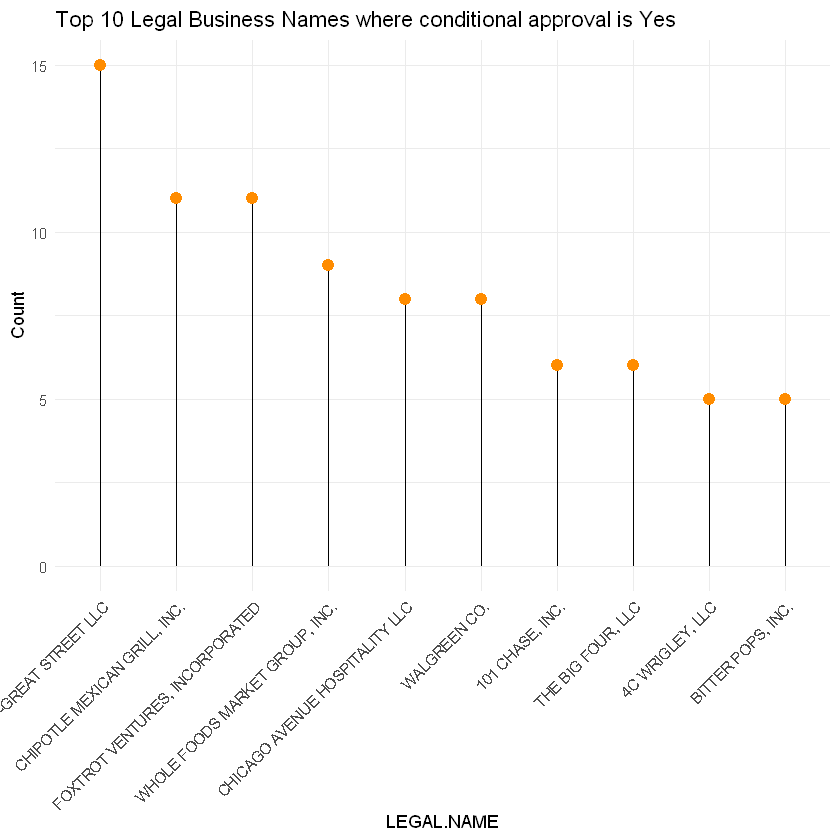

In [13]:
# Legal name - Y
legal_name <- data %>% filter(CONDITIONAL.APPROVAL == "Y")
legal_name <- create_unique_counts(legal_name, "LEGAL.NAME")
legal_name <- legal_name[order(-legal_name$Count), ]
first_10_rows <- head(legal_name, 10)

lolipop_plot <- ggplot(first_10_rows, aes(x = reorder(LEGAL.NAME, -Count), y = Count)) +
  geom_segment(aes(xend = LEGAL.NAME, yend = 0), color = "black") +
  geom_point(size = 3, color = "darkorange") +
  theme_minimal() +
  labs(title = "Top 10 Legal Business Names where conditional approval is Yes", x = "LEGAL.NAME", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(lolipop_plot)

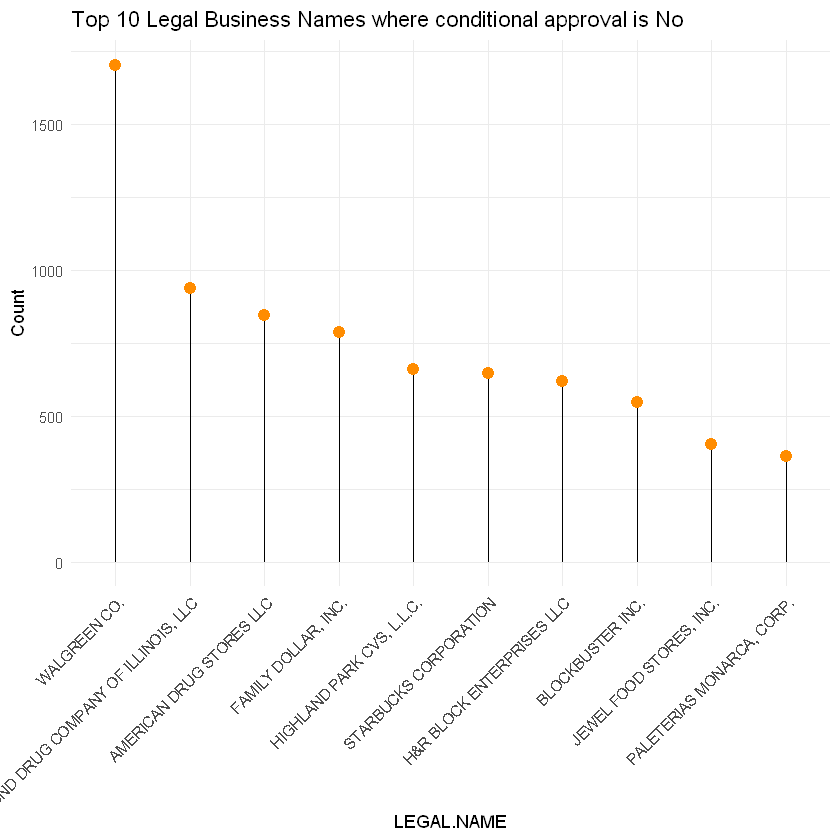

In [14]:
# Legal name - N
legal_name <- data %>% filter(CONDITIONAL.APPROVAL == "N")
legal_name <- create_unique_counts(legal_name, "LEGAL.NAME")
legal_name <- legal_name[order(-legal_name$Count), ]
first_10_rows <- head(legal_name, 10)

lolipop_plot <- ggplot(first_10_rows, aes(x = reorder(LEGAL.NAME, -Count), y = Count)) +
  geom_segment(aes(xend = LEGAL.NAME, yend = 0), color = "black") +
  geom_point(size = 3, color = "darkorange") +
  theme_minimal() +
  labs(title = "Top 10 Legal Business Names where conditional approval is No", x = "LEGAL.NAME", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(lolipop_plot)

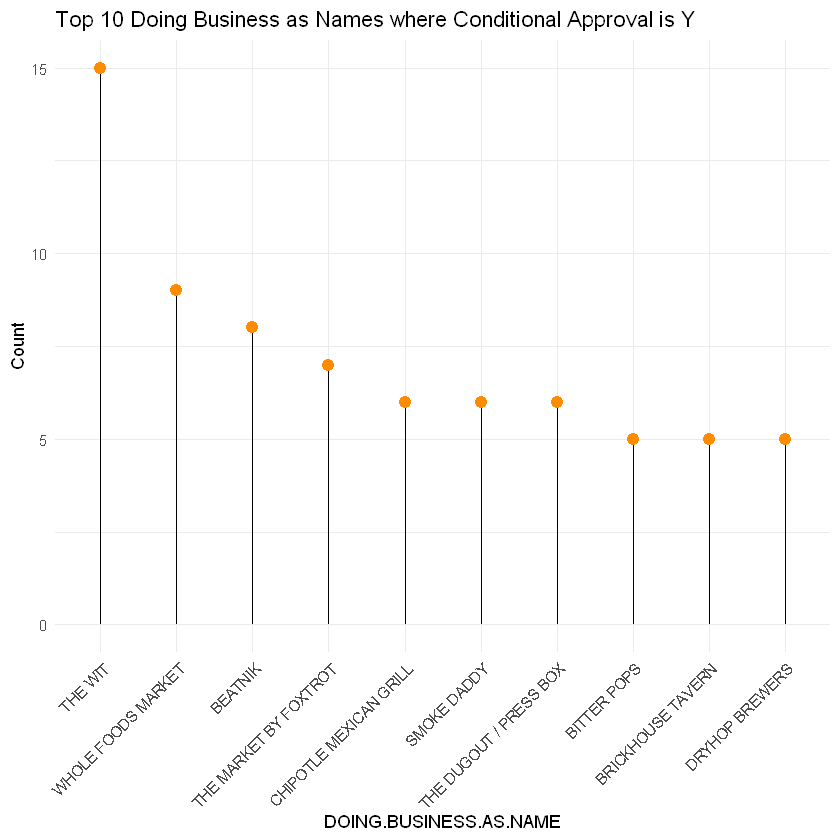

In [15]:
# DOING.BUSINESS.AS.NAME
business_name <- data %>% filter(CONDITIONAL.APPROVAL == "Y")
business_name <- create_unique_counts(business_name, "DOING.BUSINESS.AS.NAME")
business_name <- business_name[order(-business_name$Count), ]
first_10_rows <- head(business_name, 10)

lolipop_plot <- ggplot(first_10_rows, aes(x = reorder(DOING.BUSINESS.AS.NAME, -Count), y = Count)) +
  geom_segment(aes(xend = DOING.BUSINESS.AS.NAME, yend = 0), color = "black") +
  geom_point(size = 3, color = "darkorange") +
  theme_minimal() +
  labs(title = "Top 10 Doing Business as Names where Conditional Approval is Y", x = "DOING.BUSINESS.AS.NAME", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(lolipop_plot)

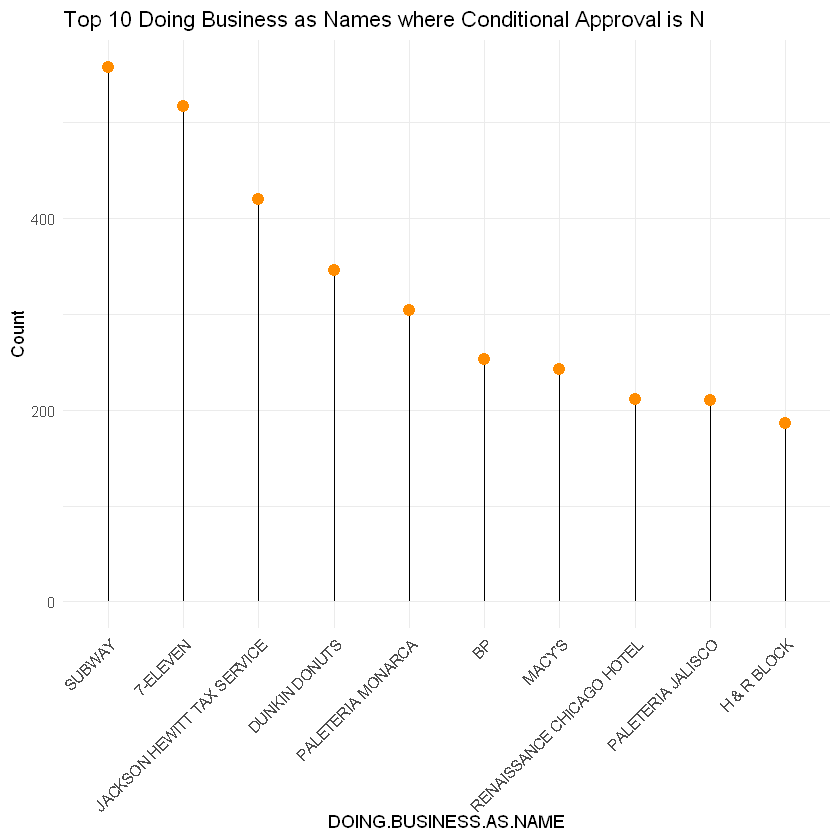

In [16]:
# DOING.BUSINESS.AS.NAME
business_name <- data %>% filter(CONDITIONAL.APPROVAL == "N")
business_name <- create_unique_counts(business_name, "DOING.BUSINESS.AS.NAME")
business_name <- business_name[order(-business_name$Count), ]
first_10_rows <- head(business_name, 10)

lolipop_plot <- ggplot(first_10_rows, aes(x = reorder(DOING.BUSINESS.AS.NAME, -Count), y = Count)) +
  geom_segment(aes(xend = DOING.BUSINESS.AS.NAME, yend = 0), color = "black") +
  geom_point(size = 3, color = "darkorange") +
  theme_minimal() +
  labs(title = "Top 10 Doing Business as Names where Conditional Approval is N", x = "DOING.BUSINESS.AS.NAME", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(lolipop_plot)

In [17]:
# city
city <- create_unique_counts(data, "CITY")
city <- city[order(-city$Count), ]
print(city)

           CITY  Count
1       CHICAGO 274137
2 HIGHLAND PARK      6
3   MINNEAPOLIS      1
4       OAKPARK      1


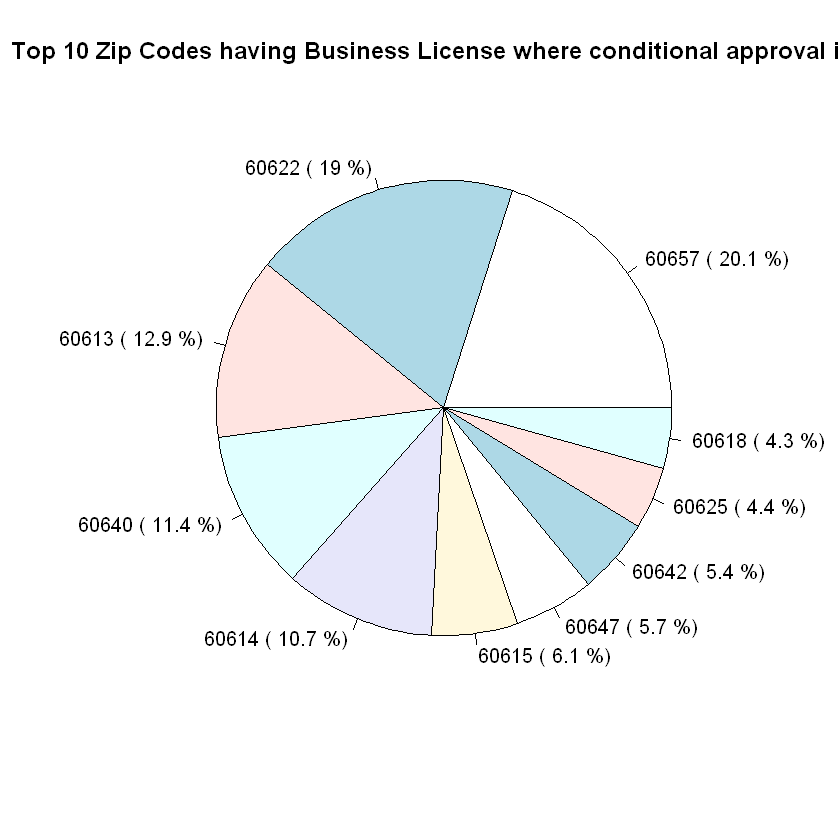

In [18]:
# Zipcode
zipcode <- data %>% filter(CONDITIONAL.APPROVAL == "Y")
zipcode <- create_unique_counts(zipcode, "ZIP.CODE")
zipcode <- zipcode[order(-zipcode$Count), ]
top_zipcode <- head(zipcode, 10)
# Calculate percentages
percentages <- round(top_zipcode$Count/sum(top_zipcode$Count) * 100, 1)
# Create labels with custom names and percentages
sector_labels <- paste(top_zipcode$ZIP.CODE, "(", percentages, "%)", sep = " ")
# Create a pie chart
pie(top_zipcode$Count, labels = sector_labels, main = "Top 10 Zip Codes having Business License where conditional approval is Y")

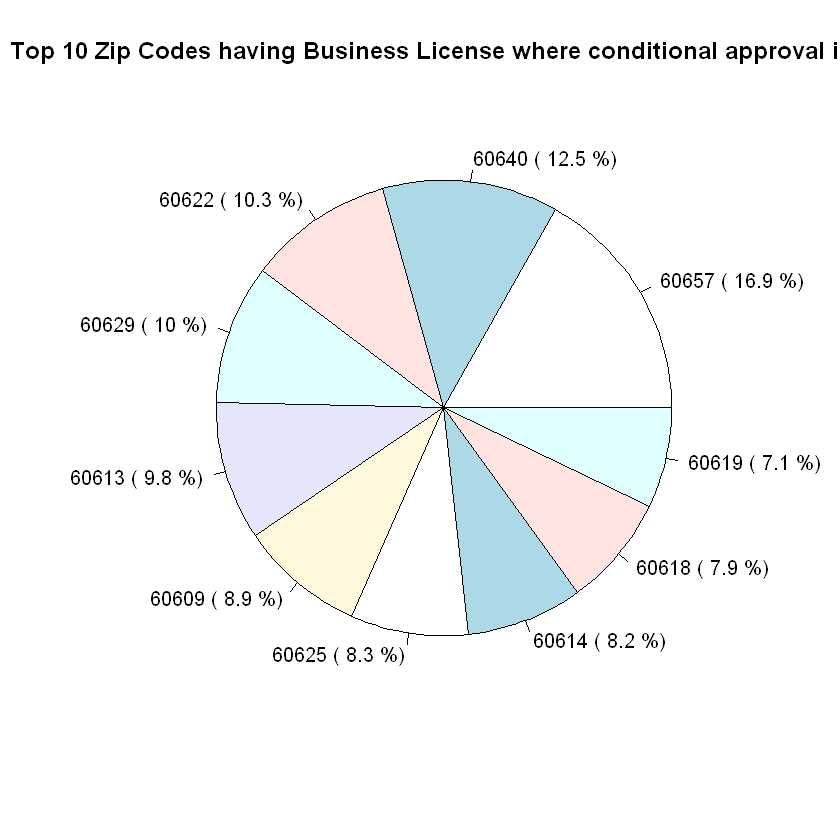

In [19]:
# Zipcode
zipcode <- data %>% filter(CONDITIONAL.APPROVAL == "N")
zipcode <- create_unique_counts(zipcode, "ZIP.CODE")
zipcode <- zipcode[order(-zipcode$Count), ]
top_zipcode <- head(zipcode, 10)
# Calculate percentages
percentages <- round(top_zipcode$Count/sum(top_zipcode$Count) * 100, 1)
# Create labels with custom names and percentages
sector_labels <- paste(top_zipcode$ZIP.CODE, "(", percentages, "%)", sep = " ")
# Create a pie chart
pie(top_zipcode$Count, labels = sector_labels, main = "Top 10 Zip Codes having Business License where conditional approval is N")

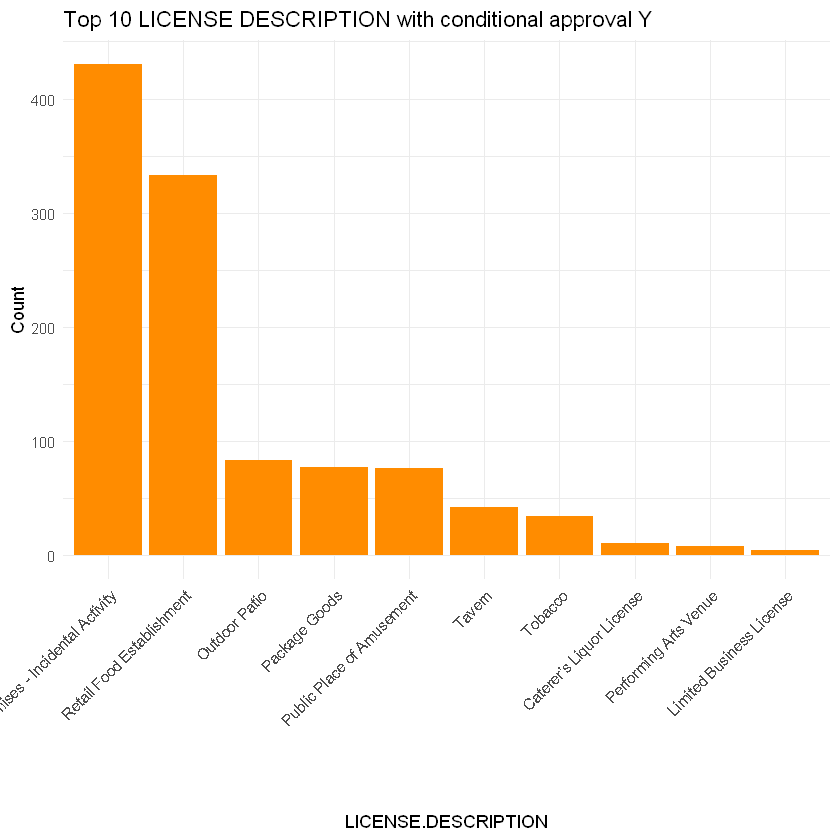

In [20]:
# LICENSE.DESCRIPTION
lic_desc <- data %>% filter(CONDITIONAL.APPROVAL == "Y")
lic_desc <- create_unique_counts(lic_desc, "LICENSE.DESCRIPTION")
lic_desc <- lic_desc[order(-lic_desc$Count), ]
first_10_rows <- head(lic_desc, 10)

bar_plot <- ggplot(first_10_rows, aes(x = reorder(LICENSE.DESCRIPTION, -Count), y = Count)) +
  geom_bar(stat = "identity", fill = "darkorange") +
  theme_minimal() +
  labs(title = "Top 10 LICENSE DESCRIPTION with conditional approval Y", 
       x = "LICENSE.DESCRIPTION", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(bar_plot)

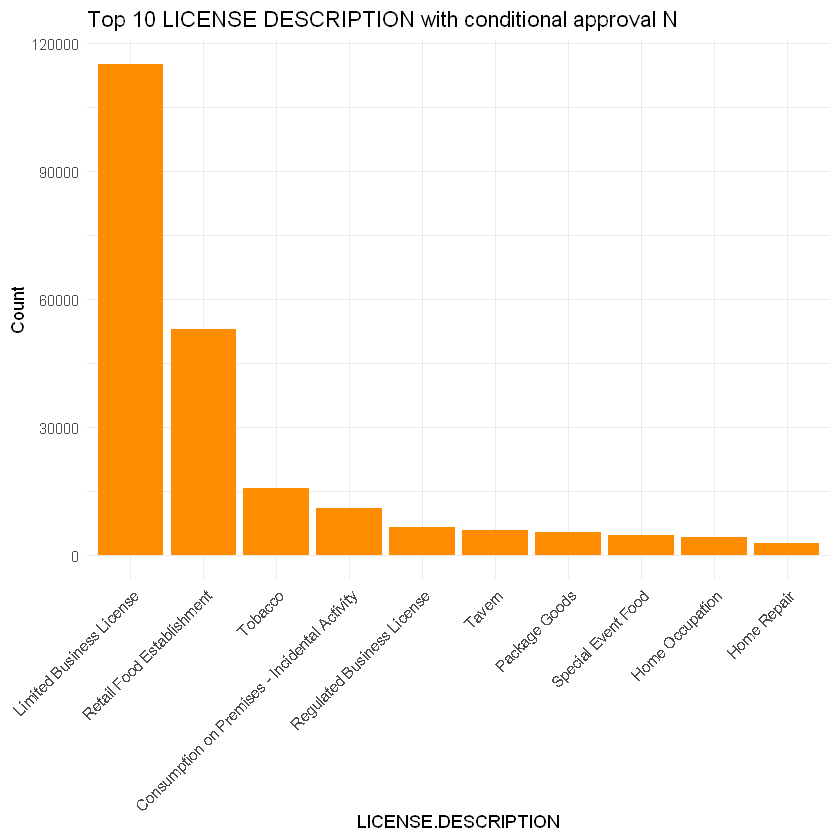

In [21]:
# LICENSE.DESCRIPTION
lic_desc <- data %>% filter(CONDITIONAL.APPROVAL == "N")
lic_desc <- create_unique_counts(lic_desc, "LICENSE.DESCRIPTION")
lic_desc <- lic_desc[order(-lic_desc$Count), ]
first_10_rows <- head(lic_desc, 10)

bar_plot <- ggplot(first_10_rows, aes(x = reorder(LICENSE.DESCRIPTION, -Count), y = Count)) +
  geom_bar(stat = "identity", fill = "darkorange") +
  theme_minimal() +
  labs(title = "Top 10 LICENSE DESCRIPTION with conditional approval N", 
       x = "LICENSE.DESCRIPTION", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(bar_plot)

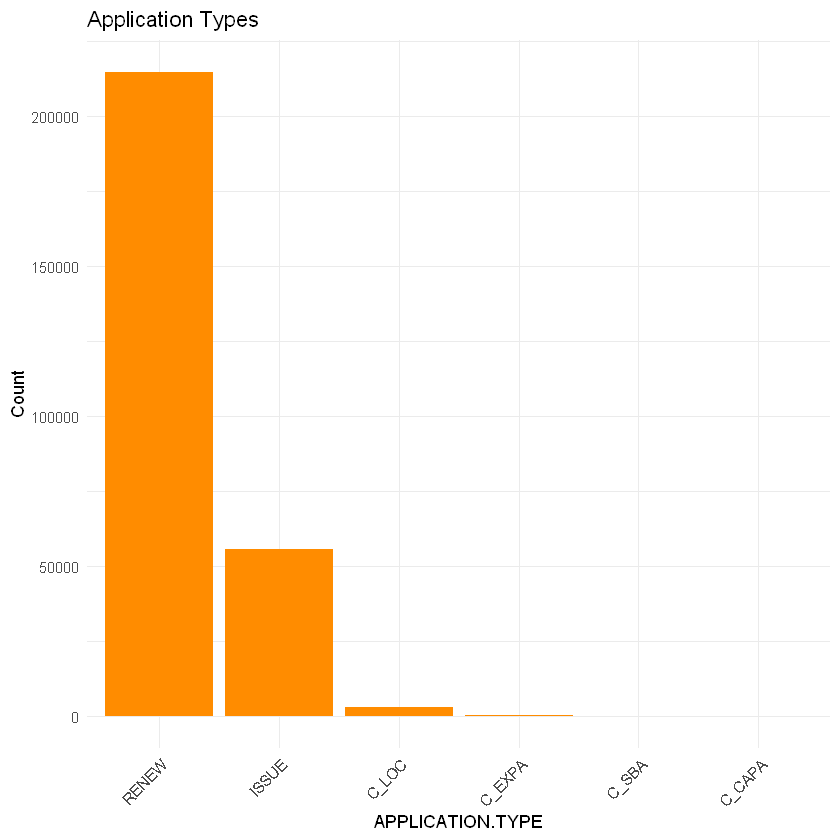

In [22]:
# APPLICATION.TYPE
app_type <- create_unique_counts(data, "APPLICATION.TYPE")
app_type <- app_type[order(-app_type$Count), ]

bar_plot <- ggplot(app_type, aes(x = reorder(APPLICATION.TYPE, -Count), y = Count)) +
  geom_bar(stat = "identity", fill = "darkorange") +
  theme_minimal() +
  labs(title = "Application Types", 
       x = "APPLICATION.TYPE", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(bar_plot)

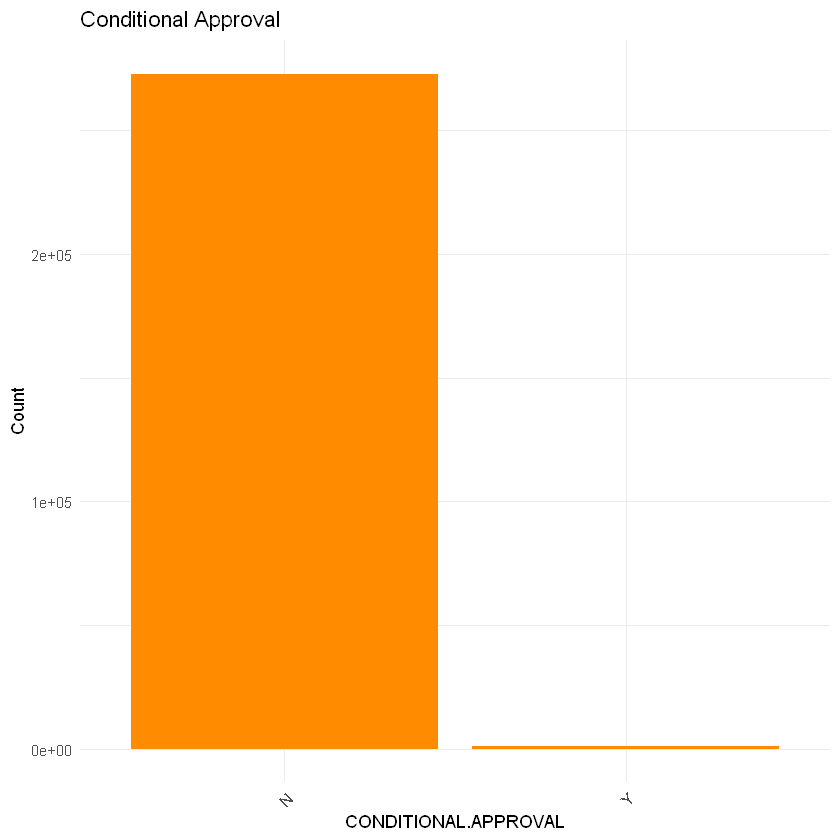

In [23]:
# CONDITIONAL.APPROVAL
cond_app <- create_unique_counts(data, "CONDITIONAL.APPROVAL")
cond_app <- cond_app[order(-cond_app$Count), ]

bar_plot <- ggplot(cond_app, aes(x = reorder(CONDITIONAL.APPROVAL, -Count), y = Count)) +
  geom_bar(stat = "identity", fill = "darkorange") +
  theme_minimal() +
  labs(title = "Conditional Approval", 
       x = "CONDITIONAL.APPROVAL", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(bar_plot)

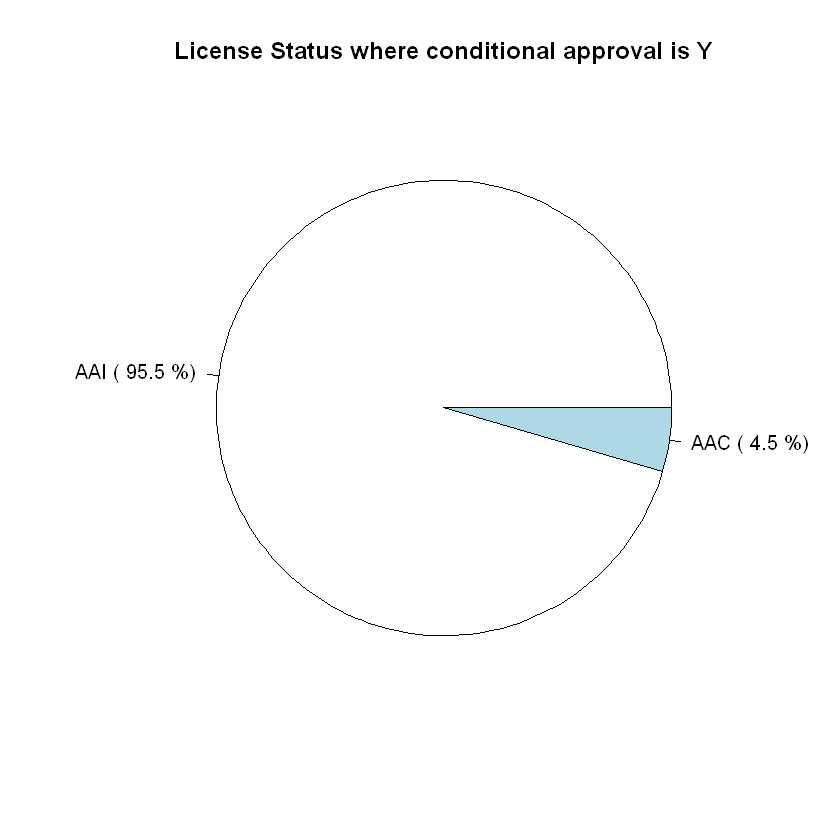

In [24]:
# LICENSE.STATUS
lic_status <- data %>% filter(CONDITIONAL.APPROVAL == "Y")
lic_status <- create_unique_counts(lic_status, "LICENSE.STATUS")
lic_status <- lic_status[order(-lic_status$Count), ]
# Calculate percentages
percentages <- round(lic_status$Count/sum(lic_status$Count) * 100, 1)
# Create labels with custom names and percentages
sector_labels <- paste(lic_status$LICENSE.STATUS, "(", percentages, "%)", sep = " ")
# Create a pie chart
pie(lic_status$Count, labels = sector_labels, main = "License Status where conditional approval is Y")

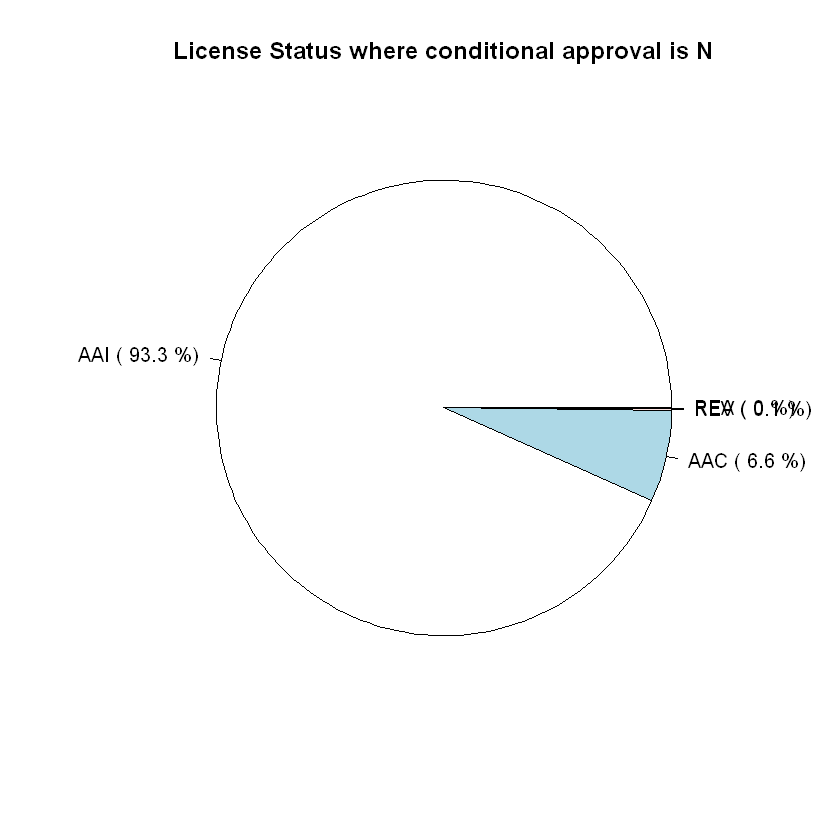

In [25]:
# LICENSE.STATUS
lic_status <- data %>% filter(CONDITIONAL.APPROVAL == "N")
lic_status <- create_unique_counts(lic_status, "LICENSE.STATUS")
lic_status <- lic_status[order(-lic_status$Count), ]
# Calculate percentages
percentages <- round(lic_status$Count/sum(lic_status$Count) * 100, 1)
# Create labels with custom names and percentages
sector_labels <- paste(lic_status$LICENSE.STATUS, "(", percentages, "%)", sep = " ")
# Create a pie chart
pie(lic_status$Count, labels = sector_labels, main = "License Status where conditional approval is N")

### Unimportant Features

In [26]:
# unimportant features based on the eda
drop_columns <- c("ID", "LEGAL.NAME", "DOING.BUSINESS.AS.NAME", "ADDRESS", "STATE", 
                  "WARD.PRECINCT", "LICENSE.DESCRIPTION", "BUSINESS.ACTIVITY",
                  "LICENSE.NUMBER", "APPLICATION.CREATED.DATE", "LICENSE.STATUS.CHANGE.DATE",
                  "LATITUDE", "LONGITUDE", "LOCATION", "LICENSE.APPROVED.FOR.ISSUANCE", "DATE.ISSUED",
                  "APPLICATION.REQUIREMENTS.COMPLETE", "PAYMENT.DATE", "LICENSE.ID", "ACCOUNT.NUMBER", 
                  "SITE.NUMBER", "CITY", "PRECINCT", "BUSINESS.ACTIVITY.ID", "Historical.Wards.2003.2015",
                  "Zip.Codes", "Wards")
data <- data[, !(names(data) %in% drop_columns)]
head(data, 5)

,ZIP.CODE,WARD,POLICE.DISTRICT,LICENSE.CODE,APPLICATION.TYPE,CONDITIONAL.APPROVAL,LICENSE.TERM.START.DATE,LICENSE.TERM.EXPIRATION.DATE,LICENSE.STATUS,SSA,Community.Areas,Census.Tracts
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
1,60613,46,19,1470,RENEW,N,06/16/2022,06/15/2024,AAI,34,31,577
2,60613,44,19,1050,RENEW,N,06/16/2020,06/15/2022,AAI,17,57,691
3,60613,46,19,1781,RENEW,N,06/16/2022,06/15/2023,AAI,18,57,83
4,60625,47,19,4409,ISSUE,N,08/08/2022,08/13/2022,AAI,21,6,667
5,60632,12,9,1010,ISSUE,N,05/11/2022,05/15/2024,AAI,39,55,196


In [27]:
# drop empty fields
data <- data %>% filter(LICENSE.TERM.START.DATE != "")
data <- data %>% filter(LICENSE.TERM.EXPIRATION.DATE != "")
data <- data %>% filter(ZIP.CODE != "")
head(data, 5)

,ZIP.CODE,WARD,POLICE.DISTRICT,LICENSE.CODE,APPLICATION.TYPE,CONDITIONAL.APPROVAL,LICENSE.TERM.START.DATE,LICENSE.TERM.EXPIRATION.DATE,LICENSE.STATUS,SSA,Community.Areas,Census.Tracts
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
1,60613,46,19,1470,RENEW,N,06/16/2022,06/15/2024,AAI,34,31,577
2,60613,44,19,1050,RENEW,N,06/16/2020,06/15/2022,AAI,17,57,691
3,60613,46,19,1781,RENEW,N,06/16/2022,06/15/2023,AAI,18,57,83
4,60625,47,19,4409,ISSUE,N,08/08/2022,08/13/2022,AAI,21,6,667
5,60632,12,9,1010,ISSUE,N,05/11/2022,05/15/2024,AAI,39,55,196


In [28]:
# Convert "DateColumn" to date format
data$LICENSE.TERM.START.DATE <- as.Date(data$LICENSE.TERM.START.DATE, format = "%m/%d/%Y")
data$LICENSE.TERM.EXPIRATION.DATE <- as.Date(data$LICENSE.TERM.EXPIRATION.DATE, format = "%m/%d/%Y")
# Calculate the number of days between the two date columns - License term
data$LICENSE.TERM <- as.numeric(data$LICENSE.TERM.EXPIRATION.DATE - data$LICENSE.TERM.START.DATE)
data <- data[, !(names(data) %in% c("LICENSE.TERM.EXPIRATION.DATE", "LICENSE.TERM.START.DATE"))]
head(data, 5)

,ZIP.CODE,WARD,POLICE.DISTRICT,LICENSE.CODE,APPLICATION.TYPE,CONDITIONAL.APPROVAL,LICENSE.STATUS,SSA,Community.Areas,Census.Tracts,LICENSE.TERM
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
1,60613,46,19,1470,RENEW,N,AAI,34,31,577,730
2,60613,44,19,1050,RENEW,N,AAI,17,57,691,729
3,60613,46,19,1781,RENEW,N,AAI,18,57,83,364
4,60625,47,19,4409,ISSUE,N,AAI,21,6,667,5
5,60632,12,9,1010,ISSUE,N,AAI,39,55,196,735


### Train and Test Data Preparation

In [29]:
set.seed(123)

# Define the proportion for random sampling
sample_proportion <- 0.7  # Proportion for random sampling

# Stratify the data
stratified_data <- data %>% group_by(CONDITIONAL.APPROVAL) %>%
  sample_frac(sample_proportion)

# Create training and testing sets
train_data <- stratified_data
test_data <- data[!rownames(data) %in% rownames(train_data), ]

In [30]:
head(train_data, 5)

ZIP.CODE,WARD,POLICE.DISTRICT,LICENSE.CODE,APPLICATION.TYPE,CONDITIONAL.APPROVAL,LICENSE.STATUS,SSA,Community.Areas,Census.Tracts,LICENSE.TERM
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
60609,15,9,1006,ISSUE,N,AAI,10,59,709,266
60661,27,12,1476,ISSUE,N,AAI,16,29,91,3
60617,8,4,1010,RENEW,N,AAI,50,44,491,729
60647,1,14,1472,RENEW,N,AAI,33,25,481,730
60601,42,1,1006,ISSUE,N,AAI,1,38,92,83


In [31]:
head(test_data, 5)

,ZIP.CODE,WARD,POLICE.DISTRICT,LICENSE.CODE,APPLICATION.TYPE,CONDITIONAL.APPROVAL,LICENSE.STATUS,SSA,Community.Areas,Census.Tracts,LICENSE.TERM
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
191460,60653,4,2,1012,ISSUE,N,AAI,47,5,395,230
191461,60619,8,4,1006,RENEW,N,AAI,50,44,490,729
191462,60659,50,24,1010,RENEW,N,AAI,43,20,31,729
191463,60619,8,6,1010,ISSUE,N,AAI,51,40,141,751
191464,60643,19,22,1010,RENEW,N,AAI,20,74,379,364


In [32]:
# View the dimensions of the training and testing sets
cat("Training data dimensions:", dim(train_data), "\n")
cat("Testing data dimensions:", dim(test_data), "\n")

Training data dimensions: 191459 11 
Testing data dimensions: 82054 11 


### Encoding 

In [34]:
# Probability encoding function
probability_encoding <- function(data, categorical_var, target_var) {
  probabilities <- data %>%
    group_by(.data[[categorical_var]]) %>%
    summarise(Probability = mean(ifelse(.data[[target_var]] == "Y", 1, 0)), .groups = "drop") %>%
    arrange(desc(Probability))
  return(probabilities)
}

In [35]:
# probability encoding of the categorical features
categorical_columns <- c(names(data[, !names(data) %in% c("CONDITIONAL.APPROVAL", "LICENSE.TERM","APPLICATION.TYPE")]))
for (cols in categorical_columns) {
  encoded <- probability_encoding(train_data, cols, "CONDITIONAL.APPROVAL")
  train_data <- left_join(train_data, encoded, by = cols)
  train_data <- train_data[, !(names(train_data) %in% c(cols))]
  test_data <- left_join(test_data, encoded, by = cols)
  test_data <- test_data[, !(names(test_data) %in% c(cols))]
  names(train_data)[names(train_data) == "Probability"] <- cols
  names(test_data)[names(test_data) == "Probability"] <- cols
}

In [36]:
dummies <- caret::dummyVars(" ~ APPLICATION.TYPE", data = train_data)
train_dummies <- as.data.frame(predict(dummies, newdata = train_data))
test_dummies <- as.data.frame(predict(dummies, newdata = test_data))
train_data <- cbind(train_data,train_dummies)
test_data <- cbind(test_data,test_dummies)
train_data <- train_data[, !(names(train_data) %in% c( "APPLICATION.TYPE"))]
test_data <- test_data[, !(names(test_data) %in% c( "APPLICATION.TYPE"))]

In [37]:
head(train_data, 5)

CONDITIONAL.APPROVAL,LICENSE.TERM,ZIP.CODE,WARD,POLICE.DISTRICT,LICENSE.CODE,LICENSE.STATUS,SSA,Community.Areas,Census.Tracts,APPLICATION.TYPEC_CAPA,APPLICATION.TYPEC_EXPA,APPLICATION.TYPEC_LOC,APPLICATION.TYPEC_SBA,APPLICATION.TYPEISSUE,APPLICATION.TYPERENEW
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N,266,0.0006350550,0.0008798944,0.0005248885,6.367365e-03,0.004168975,0.0001649621,0.000128783,0.000000000,0,0,0,0,1,0
N,3,0.0041152263,0.0077954475,0.0081512109,0.000000e+00,0.004168975,0.0035971223,0.003597122,0.005760369,0,0,0,0,1,0
N,729,0.0006436387,0.0006581545,0.0008538668,3.720976e-05,0.004168975,0.0011307101,0.001493652,0.006968641,0,0,0,0,0,1
N,730,0.0067411402,0.0121079226,0.0109575599,0.000000e+00,0.004168975,0.0107854805,0.010635667,0.021753909,0,0,0,0,0,1
N,83,0.0118918919,0.0120021822,0.0067395727,6.367365e-03,0.004168975,0.0067395727,0.006739573,0.009355509,0,0,0,0,1,0


In [38]:
head(test_data, 5)

,CONDITIONAL.APPROVAL,LICENSE.TERM,ZIP.CODE,WARD,POLICE.DISTRICT,LICENSE.CODE,LICENSE.STATUS,SSA,Community.Areas,Census.Tracts,APPLICATION.TYPEC_CAPA,APPLICATION.TYPEC_EXPA,APPLICATION.TYPEC_LOC,APPLICATION.TYPEC_SBA,APPLICATION.TYPEISSUE,APPLICATION.TYPERENEW
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,N,230,0.0009866798,0.0088737201,0.0065616798,0.000000e+00,0.004168975,0.0014673514,0.0014204545,0.000000000,0,0,0,0,1,0
2,N,729,0.0005329070,0.0006581545,0.0008538668,6.367365e-03,0.004168975,0.0011307101,0.0014936520,0.000000000,0,0,0,0,0,1
3,N,729,0.0000000000,0.0000000000,0.0025402202,3.720976e-05,0.004168975,0.0000000000,0.0000000000,0.000000000,0,0,0,0,0,1
4,N,751,0.0005329070,0.0006581545,0.0002449780,3.720976e-05,0.004168975,0.0006372471,0.0002607562,0.000000000,0,0,0,0,1,0
5,N,364,0.0015970796,0.0014806589,0.0009592326,3.720976e-05,0.004168975,0.0030131827,0.0016882386,0.002325581,0,0,0,0,0,1


In [40]:
# Select only numeric columns
numeric_cols <- sapply(test_data, is.numeric)
test_data[, numeric_cols] <- na.aggregate(test_data[, numeric_cols], FUN = mean)

In [41]:
# factorizing the target variable
data$CONDITIONAL.APPROVAL<- factor(data$CONDITIONAL.APPROVAL, levels = c("N", "Y"))

In [42]:
# Count unique values in the "Category" column
value_counts <- table(train_data$CONDITIONAL.APPROVAL)
print("Target variable distribution in training data")
# View the value counts
print(value_counts)

[1] "Target variable distribution in training data"

     N      Y 
190684    775 


In [43]:
# Count unique values in the "Category" column
value_counts <- table(test_data$CONDITIONAL.APPROVAL)
print("Target variable distribution in test data")
# View the value counts
print(value_counts)

[1] "Target variable distribution in test data"

    N     Y 
81703   351 


### Oversampling 

In [44]:
# Check the class distribution before oversampling
print("Target variable distribution in train data before oversampling")
table(train_data$CONDITIONAL.APPROVAL)

[1] "Target variable distribution in train data before oversampling"



     N      Y 
190684    775 

In [45]:
# Oversample the minority class using ROSE
oversampled_data <- ovun.sample(CONDITIONAL.APPROVAL ~ ., data = train_data, method = "over", 
                                seed = 123)
train_oversampled <- oversampled_data$data

In [46]:
# Check the class distribution after oversampling
print("Target variable distribution in train data after oversampling")
table(train_oversampled$CONDITIONAL.APPROVAL)

[1] "Target variable distribution in train data after oversampling"



     N      Y 
190684 190595 

# Training Decision Tree Model and Predicting

In [47]:
# training the decision tree model
control <- rpart.control(minsplit=20, minbucket=5, maxdepth=20)
tree_advanced <- rpart(CONDITIONAL.APPROVAL ~ ., data = train_oversampled, 
                       method="class", control=control)

In [48]:
# Predict on the test set
predictions_advanced <- predict(tree_advanced, test_data, type = "class")

In [49]:
results <- data.frame(Predictions = predictions_advanced)
results$Y_True <- test_data$CONDITIONAL.APPROVAL

In [50]:
test_data$CONDITIONAL.APPROVAL <- factor(test_data$CONDITIONAL.APPROVAL, 
                                         levels =levels(predictions_advanced))

### Evaluating the Model

In [51]:
# Evaluate the model with the Confusion Matrix
cm <- confusionMatrix(predictions_advanced, test_data$CONDITIONAL.APPROVAL)
print("Confusion Matrix for Tuned model")
cm

[1] "Confusion Matrix for Tuned model"


Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 79391     9
         Y  2312   342
                                          
               Accuracy : 0.9717          
                 95% CI : (0.9706, 0.9728)
    No Information Rate : 0.9957          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2217          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9717          
            Specificity : 0.9744          
         Pos Pred Value : 0.9999          
         Neg Pred Value : 0.1289          
             Prevalence : 0.9957          
         Detection Rate : 0.9675          
   Detection Prevalence : 0.9677          
      Balanced Accuracy : 0.9730          
                                          
       'Positive' Class : N               
                  

In [52]:
# model - evaluated metrics
print(paste("Accuracy: ", cm$overall['Accuracy']))
print(paste("Recall or Sensitivity: ", cm$byClass['Sensitivity']))
print(paste("Precision: ", cm$byClass['Pos Pred Value']))
print(paste("F1 Score: ", cm$byClass['F1']))

[1] "Accuracy:  0.971713749482048"
[1] "Recall or Sensitivity:  0.971702385469322"
[1] "Precision:  0.999886649874055"
[1] "F1 Score:  0.98559306778893"


Setting levels: control = N, case = Y

Setting direction: controls < cases



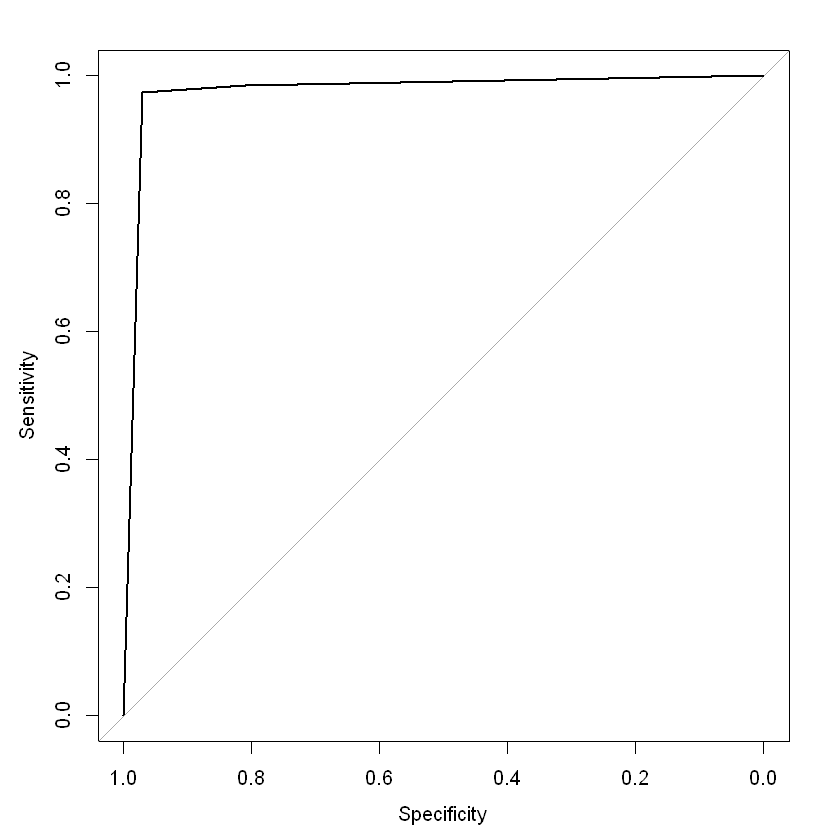

In [53]:
# auc roc curve
predicted_probabilities <- predict(tree_advanced, test_data, type="prob")[, 2]
tree_roc <- roc(test_data$CONDITIONAL.APPROVAL, predicted_probabilities)
#print(paste("AUC Score: ", tree_roc))
plot(tree_roc)

### Feature Importance 

In [54]:
# feature importance
feature_imp <- as.data.frame(tree_advanced$variable.importance)

feature_imp$Feature <- rownames(feature_imp)
rownames(feature_imp) <- NULL
names(feature_imp)[names(feature_imp) == "tree_advanced$variable.importance"] <- "Variable.Importance"
feature_imp

Variable.Importance,Feature
<dbl>,<chr>
123822.7071,APPLICATION.TYPERENEW
111758.2899,APPLICATION.TYPEISSUE
97908.2278,LICENSE.CODE
60747.6821,Census.Tracts
52592.7519,LICENSE.TERM
38491.4077,SSA
9062.7146,WARD
8374.9399,Community.Areas
2117.2390,ZIP.CODE


### Decision Tree

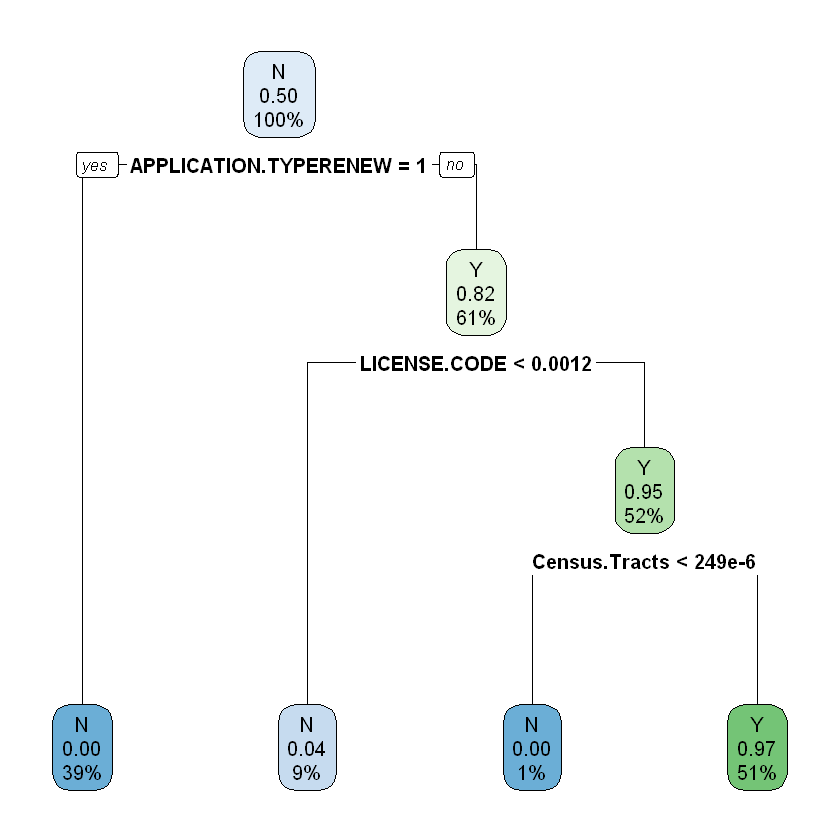

In [55]:
# decision tree
rpart.plot(tree_advanced)